# Predicting Scientific Publication Trends on arXiv: XGBoost vs ARIMA

Predicting the evolution of scientific production is valuable for both research planning and practical forecasting applications. Understanding which research trends dominate over time can inform the **optimal allocation of funding** and provide insight into **overall research productivity**.  

From a technical perspective, forecasting the number of publications over time presents a **challenging time-series problem**: the data is noisy and non-linear. This project compares the performance of **classical forecasting models (ARIMA)** with **modern machine learning approaches (XGBoost)**, highlighting the strengths and limitations of each.  

The dataset is taken from arXiv, the most popular repository for scientific publications, and contains **1 million+ papers from 2007 to 2025**, as collected from the [Kaggle arXiv Dataset](https://www.kaggle.com/datasets/jimmyyang0928/arxiv-dataset). After data cleaning and exploratory analysis, we find that recent years are dominated by **AI-related publications**, which have overtaken previously dominant **physics-related fields**. We then model the **daily publication counts** using XGBoost and compare its performance with a traditional ARIMA model, showing that XGBoost can more accurately predict the daily arXiv output for the most recent year (2024–2025).  

Beyond academia, the methods explored here are directly applicable to **business forecasting tasks**, such as predicting **market trends and product demand**.


## Exploratory Data Analysis

Let's start by importing the dataset from Kaggle and preview its content by looking at the first five rows.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jimmyyang0928/arxiv-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\dondarini\.cache\kagglehub\datasets\jimmyyang0928\arxiv-dataset\versions\1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
print(os.listdir(path))

['arxiv_dataset.csv']


In [4]:
df = pd.read_csv(os.path.join(path, 'arxiv_dataset.csv'))

In [5]:
df.head()

,id,title,authors,abstract,categories,date_submitted,date_revised,comments,doi,journal_ref
0,704.0043,Nonequilibrium entropy limiters in lattice Bol...,R. A. Brownlee; A. N. Gorban; J. Levesley,We construct a system of nonequilibrium entrop...,cond-mat.stat-mech; cond-mat.mtrl-sci,2007-03-31T17:31:12Z,2007-03-31T17:31:12Z,"30 pages, 9 figures, 1 table",http://dx.doi.org/10.1016/j.physa.2007.09.031,"Physica A, V. 387, Issues 2-3 (2008), Pages 38..."
1,704.0044,Astrophysical gyrokinetics: kinetic and fluid ...,A. A. Schekochihin; S. C. Cowley; W. Dorland; ...,We present a theoretical framework for plasma ...,astro-ph; nlin.CD; physics.plasm-ph; physics.s...,2007-03-31T17:47:54Z,2009-05-09T19:26:10Z,"aastex using emulateapj, 65 pages, 10 figures;...",http://dx.doi.org/10.1088/0067-0049/182/1/310,"ApJS 182, 310 (2009)"
2,704.0045,Evolution of solitary waves and undular bores ...,G. A. El; R. H. J. Grimshaw; A. M. Kamchatnov,This paper considers the propagation of shallo...,nlin.PS; nlin.SI,2007-03-31T18:09:02Z,2007-03-31T18:09:02Z,accepted for publication in J. Fluid Mech.,http://dx.doi.org/10.1017/S0022112007006817,"J. Fluid Mech. 585, 213-244 (2007)"
3,704.0046,A limit relation for entropy and channel capac...,I. Csiszar; F. Hiai; D. Petz,"In a quantum mechanical model, Diosi, Feldmann...",quant-ph; cs.IT; math.IT,2007-04-01T16:37:36Z,2007-04-01T16:37:36Z,"LATEX file, 11 pages",http://dx.doi.org/10.1063/1.2779138,"J. Math. Phys. 48(2007), 092102."
4,704.0047,Intelligent location of simultaneously active ...,T. Kosel; I. Grabec,The intelligent acoustic emission locator is d...,cs.NE; cs.AI,2007-04-01T13:06:50Z,2007-04-01T13:06:50Z,"5 pages, 5 eps figures, uses IEEEtran.cls",NaN,NaN


Let's preview the `info` of the dataset to have a better visualization of its content.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1396153 entries, 0 to 1396152
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   id              1396153 non-null  float64
 1   title           1396153 non-null  object 
 2   authors         1396153 non-null  object 
 3   abstract        1396153 non-null  object 
 4   categories      1396153 non-null  object 
 5   date_submitted  1396153 non-null  object 
 6   date_revised    1396153 non-null  object 
 7   comments        943141 non-null   object 
 8   doi             502462 non-null   object 
 9   journal_ref     340770 non-null   object 
dtypes: float64(1), object(9)
memory usage: 106.5+ MB


The dataset consists of approximately 1.4 million publications covering the period from 2007 to 2025. Each paper has a unique arXiv `id` and includes metadata such as `title`, `authors`, and `abstract`. The dataset contains several interesting columns worth exploring; a natural choice is the `category` column, which indicates the field of the publication. Note that a paper can belong to multiple categories (a "cross-list"). Let's examine the unique categories in the dataset using `value_counts`.

In [7]:
df['categories'].value_counts()

categories
cs.CV                                                51327
quant-ph                                             32035
cs.CL                                                22477
hep-ph                                               21878
cond-mat.mtrl-sci                                    20174
                                                     ...  
math.PR; cs.DM; 37B15, 60J05, 60K35                      1
math.AP; 35R01, 35N25, 58J05                             1
math.NA; 65H05; G.1.5                                    1
cs.DM; F.2.2; G.1.6                                      1
math.RA; 16D90, 16T05, 16T10, 17A30, 17A36, 17A60        1
Name: count, Length: 212113, dtype: int64

For a full description of the categories and their acronyms, see: https://arxiv.org/category_taxonomy.  
In our analysis, we focus on the *primary category*—that is, the first category listed for each paper—which typically provides the most accurate description of its content.  

Let's create a new column, `primary_category`, by extracting the first entry from the `category` column.


In [8]:
df['primary_category'] = df['categories'].str.split(';').str[0]

In [9]:
df['primary_category'].head()

0    cond-mat.stat-mech
1              astro-ph
2               nlin.PS
3              quant-ph
4                 cs.NE
Name: primary_category, dtype: object

Next, we examine the most popular categories.  
We `groupby` the `primary_category` column and `count` how many papers fall into each category. Then we apply `sort_values` to order the resulting dataframe from the most to the least represented category.  

Finally, let's preview the first ten rows of the resulting `pop_categories` dataframe.


In [10]:
pop_categories = df.groupby('primary_category').agg({'id':'count'}).reset_index()
pop_categories = pop_categories.rename(columns = {'id':'paper_no'})

pop_categories = pop_categories.sort_values(by = 'paper_no', ascending = False)

pop_categories.head(10)

,primary_category,paper_no
23,cs.CV,88881
38,cs.LG,78701
147,quant-ph,57112
21,cs.CL,49825
66,hep-ph,45002
67,hep-th,34840
9,cond-mat.mtrl-sci,32817
8,cond-mat.mes-hall,29573
71,math.AP,29415
3,astro-ph.GA,29157


Here is a bar chart showing the 10 most popular categories.

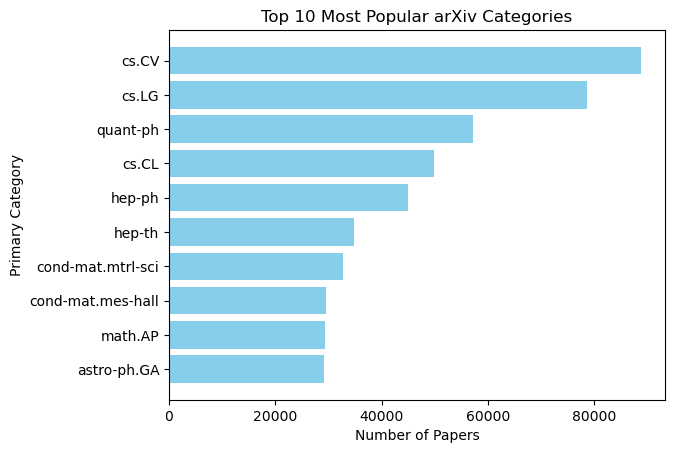

In [11]:
top10 = pop_categories.head(10)
#plt.figure(figsize=(10,6))
plt.barh(top10['primary_category'][::-1], top10['paper_no'][::-1], color='skyblue')
plt.xlabel('Number of Papers')
plt.ylabel('Primary Category')
plt.title('Top 10 Most Popular arXiv Categories')
plt.show()


Interesting: the top category is a computer science one (cs), in particular cs.CV (Computer Vision and Pattern Recognition) with 88881 publications. Note that the top five most popular categories are dominated by computer science domains: cs.LG (Machine Learning), 78701 publications, and cs.CL (Computation and Language), 49825 publications. The other two top-five categories are instead physics related: quant-ph (Quantum Physics), 57112 publications, and hep-ph (High Energy Physics - Phenomenology), 45002 publications. This trend immediatley triggers a question: what is the time evolution of the number of papers for each category? And how did we get to this distribution?

To address these questions, we move into the realm of time series analysis. In particular, it is useful to study the daily evolution of published papers—both in total and broken down by category. Before exploring any forecasting methods, we first need to extract the relevant features for our time series.

As a starting point, we keep only the Year–Month–Day information from the `date_submitted` column.


In [12]:
df['YMD_timestamp'] = pd.to_datetime(df['date_submitted']).dt.to_period('D')
df['YMD_timestamp'].head()

C:\Users\dondarini\AppData\Local\Temp\ipykernel_7692\441927910.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['YMD_timestamp'] = pd.to_datetime(df['date_submitted']).dt.to_period('D')


0    2007-03-31
1    2007-03-31
2    2007-03-31
3    2007-04-01
4    2007-04-01
Name: YMD_timestamp, dtype: period[D]

Next, we create the `all_paper_evo` dataframe by `groupby`-ing by day and counting the number of papers published each day. This dataframe will serve as the basis for our time series analysis.

In [13]:
all_paper_evo = df.groupby('YMD_timestamp').agg({'id':'count'}).reset_index()

all_paper_evo = all_paper_evo.rename(columns = {'id':'paper_no'})
all_paper_evo.head()

,YMD_timestamp,paper_no
0,2007-03-31,12
1,2007-04-01,47
2,2007-04-02,184
3,2007-04-03,56
4,2007-04-04,166


Let's print the length of the dataframe to inspect how many days are collected.

In [14]:
len(all_paper_evo)

6034

A particularly relevant quantity is the rolling average, which shows the average number of papers over a given time period (window). Here, we use a year-based rolling average with a 365-day window. 

The rolling average is also especially useful for visualizing long-term trends, as it smooths out the short-term peaks and fluctuations in the time series.  

Let's plot our dataframe and overlay the rolling average.


In [15]:
all_paper_evo['roll_visual'] = all_paper_evo['paper_no'].rolling(window=365).mean()

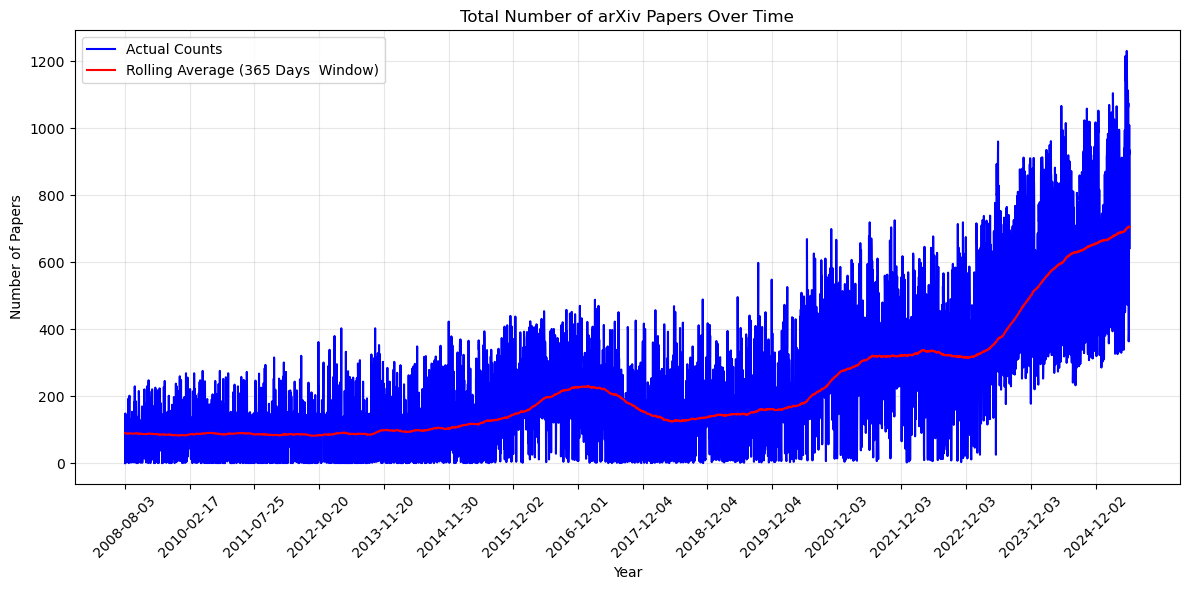

In [43]:
plt.figure(figsize=(12,6))
plt.plot(all_paper_evo['YMD_timestamp'].astype(str), all_paper_evo['paper_no'], color='blue', label = "Actual Counts")
plt.plot(all_paper_evo['YMD_timestamp'].astype(str), all_paper_evo['roll_visual'], color='red', label = "Rolling Average (365 Days  Window)")
plt.title('Total Number of arXiv Papers Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
step = 365
plt.xticks(ticks=range(0, len(all_paper_evo), step), 
           labels=all_paper_evo['YMD_timestamp'].astype(str)[::step], 
           rotation=45)

plt.tight_layout()
plt.savefig('../results/arXiv_TimeSeries.png', dpi=300, bbox_inches='tight')
plt.show()

From the plot, it is clear that the number of daily publications shows a rising trend, which becomes significant around 2018. What drives this increase? To investigate, we can examine the time evolution of the top categories identified earlier to see if the trend is driven by specific research fields.  

To do this, we `groupby` both category and day, and then create a pivot table, `category_paper_evo_pivot`, with `YMD_timestamp` as the index and `primary_category` along with `paper_no` as the values.


In [17]:
category_paper_evo = df.groupby(['primary_category', 'YMD_timestamp']).agg({'id':'count'}).reset_index()
category_paper_evo = category_paper_evo.rename(columns = {'id':'paper_no'})
category_paper_evo_pivot = category_paper_evo.pivot_table(index = 'YMD_timestamp', columns = 'primary_category', values = 'paper_no').fillna(0)

category_paper_evo_pivot.head()

primary_category,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,cond-mat.mes-hall,cond-mat.mtrl-sci,...,q-fin.PR,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT
YMD_timestamp,,,,,,,,,,,,,,,,,,,,,
2007-03-31,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-04-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2007-04-02,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,12.0,...,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0
2007-04-03,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2007-04-04,28.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,5.0,...,1.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0


Next, let's plot the time series for each of the top five categories.  

Since the raw data exhibits highly oscillatory patterns, the plot would be difficult to interpret. To better visualize the trends, we will display only the rolling averages.


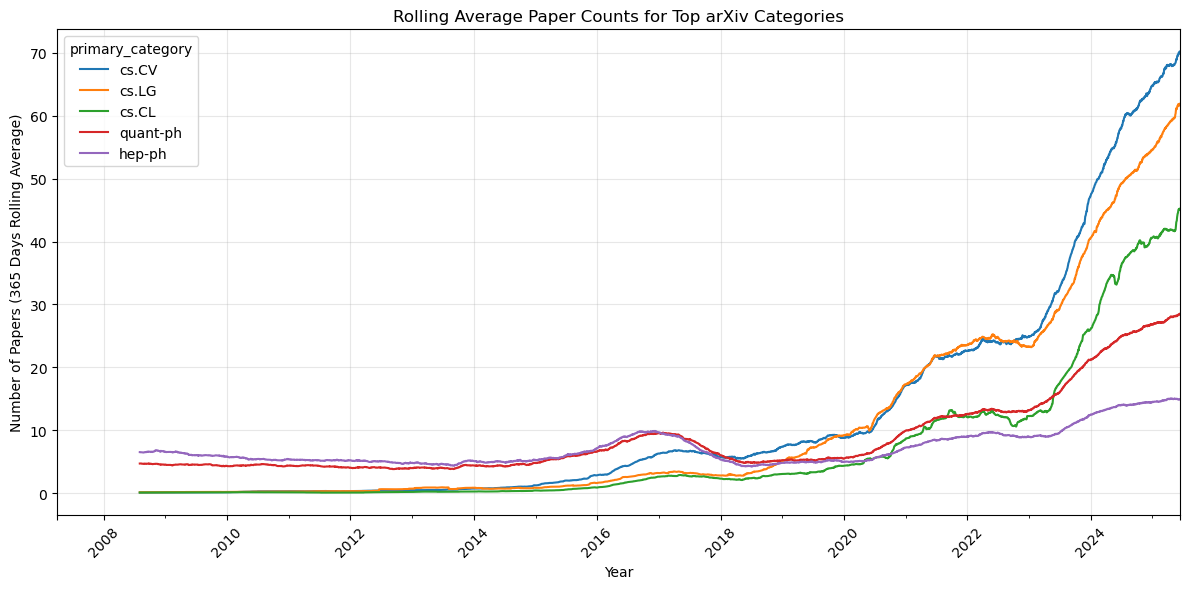

In [18]:
top_categories = ['cs.CV', 'cs.LG', 'cs.CL', 'quant-ph', 'hep-ph']

category_paper_evo_pivot[top_categories].rolling(window=365).mean().plot(
    figsize=(12,6),
    kind='line'
    )

plt.title('Rolling Average Paper Counts for Top arXiv Categories')
plt.xlabel('Year')
plt.ylabel('Number of Papers (365 Days Rolling Average)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Interestingly, the recent increase in total arXiv publications is driven almost entirely by the explosive growth of AI-related categories. Beginning around 2021–2022, machine learning fields started to surpass the historically dominant physics categories. This aligns with the major acceleration in AI research and model development that occurred during that period. Today, AI-related submissions exceed all other fields by a wide margin.  

Given these observations and the clear upward trend, it is particularly timely to perform a Time Series Analysis to forecast the daily evolution of paper submissions.


## Time Series Analysis: Predicting  the Evolution of Research Trends with XGBoost 

From the previous plots, it is clear that the time series we are dealing with is not stationary. Both the mean and standard deviation vary over time, as evidenced by the rising trend (confirmed by the increasing rolling average) and the changing amplitude of the oscillations.  As a consequence, ML-based algorithms can be a valid alternative to more traditional forecasting methods, which typically require stationarity in the time series. Of course, strategies to make a time series as stationary as possible can still be applied, allowing traditional forecasting methods to be used. This will be the focus of the next section, where we build an ARIMA model as a useful baseline to evaluate whether ML algorithms can outperform traditional approaches in forecasting the number of daily publications over time.  

In this section, we develop a machine learning model based on the XGBoost algorithm: an ensemble method that builds a sequence of decision trees, each aiming to minimize the residual errors of the previous predictions recursively.


Before delving into the XGBoost algorithm, we need to build the relevant features. In a time series, the observed value at time *t* is typically correlated with past values. To capture these dependencies, we introduce *lagged features*, which link the current value to specific past values. Specifically, we create the `lag7` column for a 7-day lag (one week), as well as `lag30`, `lag60`, and `lag365` for one-month, two-month, and one-year lags.  

In addition, adding smoothed features can help the model detect long-term trends. To this end, we introduce rolling averages over 1 week, 3 months, and 6 months, which are stored in the `roll7`, `roll90`, and `roll180` columns.


In [19]:
all_paper_evo['lag7']  = all_paper_evo['paper_no'].shift(7)   # 1 week ago
all_paper_evo['lag30']  = all_paper_evo['paper_no'].shift(30)   # 1 month ago
all_paper_evo['lag60']  = all_paper_evo['paper_no'].shift(60)   # 2 months ago
all_paper_evo['lag365'] = all_paper_evo['paper_no'].shift(365)  # 1 year ago

all_paper_evo['roll7']  = all_paper_evo['paper_no'].rolling(7).mean()   # ~7 days trend
all_paper_evo['roll90']  = all_paper_evo['paper_no'].rolling(90).mean()   # ~3 months trend
all_paper_evo['roll180'] = all_paper_evo['paper_no'].rolling(180).mean()  # ~6 months trend


Naturally, the first 364 rows of the dataframe cannot be linked to any `lag365` values by construction. As a result, the feature engineering process described so far generates 364 rows containing `NaNs`, which we drop for practical purposes.


In [20]:
all_paper_evo = all_paper_evo.dropna()

all_paper_evo.head()

,YMD_timestamp,paper_no,roll_visual,lag7,lag30,lag60,lag365,roll7,roll90,roll180
365,2008-08-03,1,90.416438,36.0,125.0,185.0,12.0,57.285714,88.633333,86.694444
366,2008-08-04,9,90.312329,61.0,5.0,114.0,47.0,49.857143,87.788889,86.216667
367,2008-08-05,149,90.216438,53.0,59.0,101.0,184.0,63.571429,88.911111,86.905556
368,2008-08-06,1,90.065753,133.0,191.0,63.0,56.0,44.714286,88.900000,86.483333
369,2008-08-13,141,89.997260,14.0,45.0,60.0,166.0,62.857143,90.166667,86.177778


In [21]:
len(all_paper_evo)

5669

Visual inspection shows that our time series exhibits a distinct behavior: it is approximately stationary during the early years, while starting around 2018, a significant upward trend emerges. The most interesting part of the series is therefore the 2018–2025 period.  

To optimize our ML algorithm, we restrict the dataset to this timeframe. This focuses the training set on the rising trend, enabling the model to better capture and forecast the evolution of daily publications in the test set.  

In short, we concentrate on the less stationary portion of the time series — the most recent years, from 2018 to today.


In [22]:
all_paper_evo_cut = all_paper_evo.iloc[3000:]

len(all_paper_evo_cut)

2669

We now move on to splitting the data. Specifically, we divide the dataset into training, validation, and test sets. Following standard practice—and to help the model effectively learn the rising trend—we apply an 80%-10%-10% split.  

For the feature matrix `X`, we include all the lag-based features as well as the `roll90` column, which captures the 3-month rolling average. The target variable `y` is the current number of daily papers published at time *t*.


In [23]:

n = len(all_paper_evo_cut)

idx_train = int(n * 0.80)
idx_val = int(n * 0.1)
idx_test = int(n * 0.1)
f_list = ['lag7','lag30','lag60', 'lag365','roll90']
X = all_paper_evo_cut[f_list]
y = all_paper_evo_cut['paper_no']

X_train = X.iloc[:idx_train]
X_val = X.iloc[idx_train:idx_train+idx_val]
X_test = X.iloc[idx_train+idx_val:]

y_train = y.iloc[:idx_train]
y_val = y.iloc[idx_train:idx_train+idx_val]
y_test = y.iloc[idx_train+idx_val:]





Let's plot the three different datasets for visual clarity.

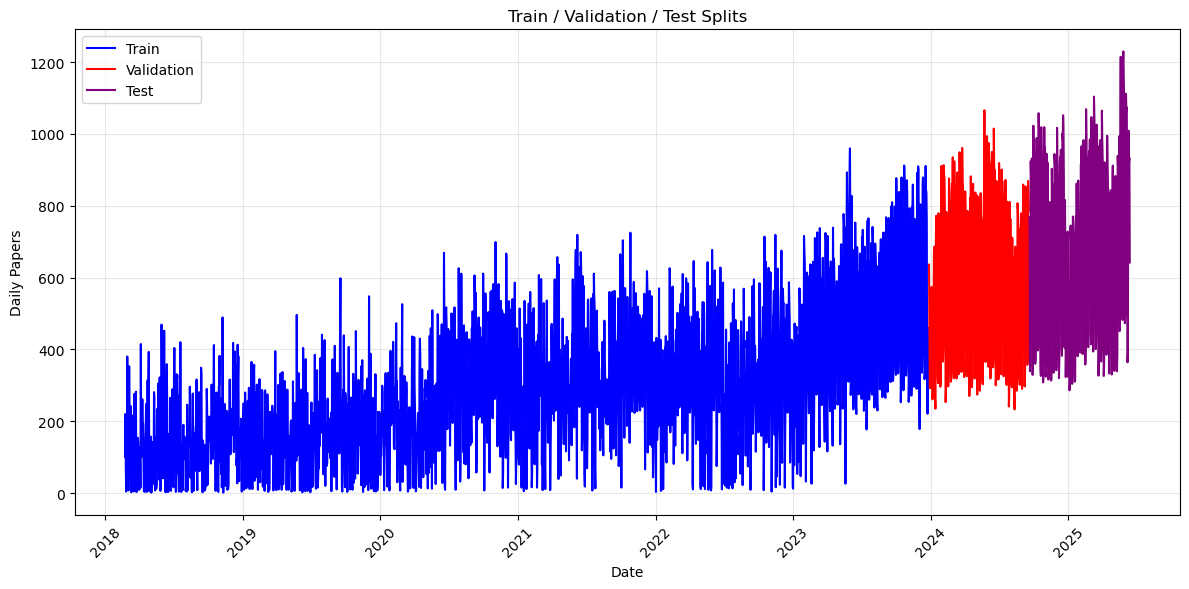

In [24]:
plt.figure(figsize=(12,6))

plt.plot(all_paper_evo_cut.iloc[:idx_train]['YMD_timestamp'].dt.to_timestamp(), 
         all_paper_evo_cut.iloc[:idx_train]['paper_no'], 
         color='blue', label='Train')

plt.plot(all_paper_evo_cut.iloc[idx_train:idx_train+idx_val]['YMD_timestamp'].dt.to_timestamp(), 
         all_paper_evo_cut.iloc[idx_train:idx_train+idx_val]['paper_no'], 
         color='red', label='Validation')

plt.plot(all_paper_evo_cut.iloc[idx_train+idx_val:]['YMD_timestamp'].dt.to_timestamp(), 
         all_paper_evo_cut.iloc[idx_train+idx_val:]['paper_no'], 
         color='purple', label='Test')

plt.xlabel('Date')
plt.ylabel('Daily Papers')
plt.title('Train / Validation / Test Splits')
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Once the splits are completed, we are ready to build the XGBoost model. As a first step, we perform hyperparameter tuning by training the model while scanning over different values of the maximum tree depth. This parameter is particularly important, as deeper trees are more expressive but also more prone to overfitting. For the remaining hyperparameters, we fix the number of estimators to 1000 and the learning rate to 0.01. For each value of the maximum depth, we compute the mean squared error (MSE) on both the training and validation sets. Plotting these curves across the scanned depths allows us to diagnose potential underfitting or overfitting.


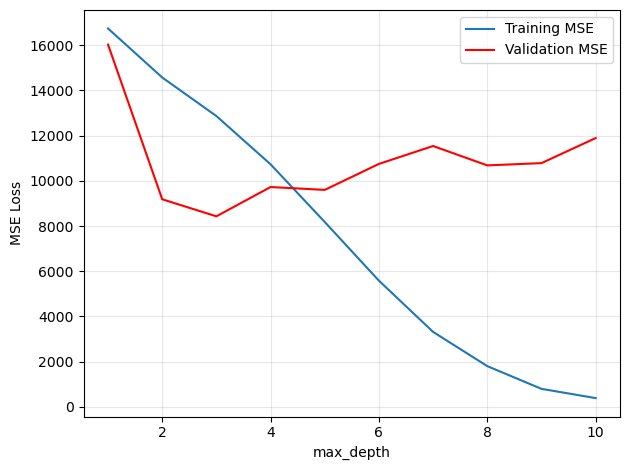

In [25]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

train_loss_list = []
val_loss_list = []
depth_list = range(1,11)

for d in depth_list:
    model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01,
    max_depth= d,
    n_estimators=1000)

    model.fit(X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
          verbose=False)
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    train_loss_list.append(mean_squared_error(y_train, pred_train))
    val_loss_list.append(mean_squared_error(y_val, pred_val))
    


plt.plot(depth_list,train_loss_list, label = 'Training MSE')
plt.plot(depth_list, val_loss_list, c= 'red', label = 'Validation MSE')

plt.xlabel('max_depth')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

    

From the plot above, it is clear that for our baseline choice of `n_estimators` and `learning_rate`, the optimal value of `max_depth` is 3. This corresponds to the minimum of the validation loss. Choosing a smaller `max_depth` results in high and very similar training and validation losses, which indicates underfitting. Conversely, selecting `max_depth` values larger than 3 causes the validation loss to increase while the training loss continues to decrease, a clear sign of overfitting.

With the `max_depth = 3` optimal choice in hand we are now ready to retrain the model on the `X_train`+`X_val` set.

In [26]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01,
    max_depth=3,
    n_estimators=1000
)

model.fit(X_train_val, y_train_val,
    eval_set=[(X_train_val, y_train_val)],
          verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [27]:
model.feature_importances_

array([0.7674493 , 0.02134359, 0.02314608, 0.01861484, 0.16944616],
      dtype=float32)

Interestingly, calling `feature_importances_` on the model reveals that the two most relevant features are `lag7` (about 77%) and `roll90` (about 17%). This makes intuitive sense: short lags help the model handle the highly noisy day-to-day fluctuations, while a large-window rolling average provides information about longer-term trends.

Finally, we are ready to make forecasts on the test set. We call `predict` on the trained model and overlay the predicted test values onto the actual data. This visual comparison helps us build intuition about the quality of the predictions.

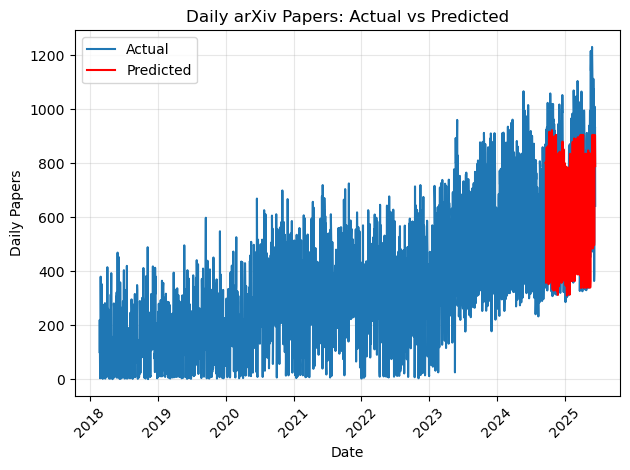

In [28]:
y_pred_test = model.predict(X_test)


plt.plot(all_paper_evo_cut['YMD_timestamp'].dt.to_timestamp(),all_paper_evo_cut['paper_no'], label= 'Actual')
plt.plot(all_paper_evo_cut.iloc[idx_train+idx_val:]['YMD_timestamp'].dt.to_timestamp(), y_pred_test, c= 'red', label = 'Predicted')

plt.xlabel('Date')
plt.ylabel('Daily Papers')
plt.title('Daily arXiv Papers: Actual vs Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Because of the strong noise and oscillatory behavior in the data, it is difficult to visually assess the quality of the predictions. Let's zoom in on the relevant portion to get a clearer view.


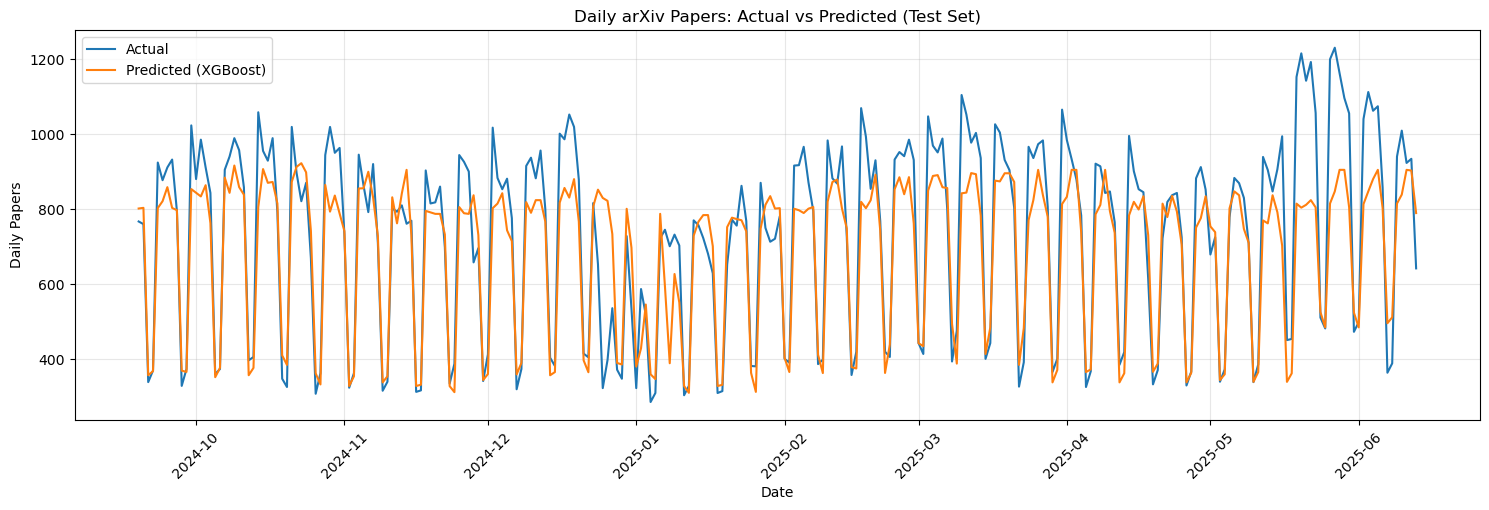

In [29]:
plt.figure(figsize=(15,5))
plt.plot(all_paper_evo_cut['YMD_timestamp'][idx_train+idx_val:].dt.to_timestamp(), y_test.values, label='Actual')
plt.plot(all_paper_evo_cut['YMD_timestamp'][idx_train+idx_val:].dt.to_timestamp(), y_pred_test, label='Predicted (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Daily Papers')

plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend()
plt.title("Daily arXiv Papers: Actual vs Predicted (Test Set)")
plt.savefig('../results/XGBoost_predictions.png', dpi=300, bbox_inches='tight')
plt.show()


Not bad! From a first visual inspection, we see that the model captures the overall oscillatory trend quite well. However, it still struggles to reproduce the sharp resonant peaks. To be more quantitative, let's compute the $R^2$-score on the test set.


In [30]:
from sklearn.metrics import r2_score

r2_test = r2_score(y_test, y_pred_test)
print("TEST R²:", r2_test)




TEST R²: 0.7714427709579468


The result is promising: we obtain an $R^2$-score of about 77%, which is reasonably close to 1. Further improvements could be achieved, for example, by performing a more thorough exploration of the hyperparameter space to enhance the model’s performance.

The next natural question is: how does this ML model compare to a traditional time series forecasting method? To investigate, we build an Autoregressive Integrated Moving Average (ARIMA) model, compute the resulting $R^2$ on the test set, and finally compare the metrics between the two approaches.


## Comparison with a Traditional Model: ARIMA

When building ARIMA models, forecasting relies on three key components:

1. **Stationarity transformation:** We transform the dataset to make the time series as stationary as possible (Integration, I). In practice, this is achieved in ARIMA by differencing the data $d$ times to remove trends and, ideally, obtain an approximately time-independent mean.

2. **Autoregressive and Moving-Average components:** The current value at time $t$ is modeled as a linear combination of $p$ lagged values (Autoregressive, AR) and $q$ lagged forecast errors (Moving-Average, MA).

These operations define the ARIMA$(p,d,q)$ model.

Before implementing the model, we split the original time series into training and test sets. Note that a separate validation set is not strictly necessary, as hyperparameter tuning can be guided by inspecting the Auto-Correlation Function (ACF) and Partial Auto-Correlation Function (PACF) of the series (see below).


In [31]:
ts = all_paper_evo_cut.copy()

ts['YMD_timestamp'] = ts['YMD_timestamp'].dt.to_timestamp()


ts_train = ts.iloc[:idx_train+idx_val]
ts_test  = ts.iloc[idx_train+idx_val:]

Besides stabilizing the mean, achieving stationarity also requires making the variance of the time series approximately constant. One practical approach is to perform a Box-Cox transformation, which applies a power transformation controlled by a parameter $\lambda$. The optimal $\lambda$ is chosen to make the transformed data as close to normally distributed as possible. If $\lambda$ is close to 1, it suggests that the original data are already approximately normally distributed. Conversely, values of $\lambda$ near 0 indicate that the data follow an approximately exponential distribution.

The `boxcox` function from the `scipy.stats` module implements this transformation. Let's apply it to the training set and print the resulting value of $\lambda$.



In [32]:
from scipy.stats import boxcox

ts_train['bc_transform'], lam = boxcox(ts_train['paper_no'])

print(lam)

0.5158257987758657


C:\Users\dondarini\AppData\Local\Temp\ipykernel_7692\1212341202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_train['bc_transform'], lam = boxcox(ts_train['paper_no'])


In our case, we find that $\lambda \approx 0.52$, which represents an intermediate case between an exponential and a normal distribution.  

Next, we apply the same transformation to the test set using the $\lambda$ value obtained from the training set. This ensures that we avoid any data leakage.


In [33]:
def box_cox_series(x, lam):
    if lam == 0:
        return np.log(x)
    return (x**lam - 1) / lam

ts_test['bc_transform'] = box_cox_series(ts_test['paper_no'], lam)


C:\Users\dondarini\AppData\Local\Temp\ipykernel_7692\2276973396.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_test['bc_transform'] = box_cox_series(ts_test['paper_no'], lam)


In [34]:
ts_test.head()

,YMD_timestamp,paper_no,roll_visual,lag7,lag30,lag60,lag365,roll7,roll90,roll180,bc_transform
5766,2024-09-19,767,636.657534,777.0,786.0,301.0,720.0,678.000000,625.211111,650.450000,57.702896
5767,2024-09-20,760,636.520548,771.0,754.0,805.0,810.0,676.428571,630.322222,652.466667,57.421501
5768,2024-09-21,339,635.673973,357.0,720.0,811.0,648.0,673.857143,630.577778,649.011111,37.203019
5769,2024-09-22,370,635.832877,372.0,639.0,725.0,312.0,673.571429,625.033333,646.272222,39.010205
5770,2024-09-23,924,637.490411,869.0,318.0,755.0,319.0,681.428571,626.444444,646.627778,63.716247


Next, we perform first-order differencing $d = 1$ to help stabilize the mean.  
It is important to note that at this stage we carry out the differencing manually **only for visualization purposes**. The ARIMA implementation we will use later already applies differencing internally based on the specified value of $d$, so we will not manually difference the data when fitting the actual model.


In [35]:
ts_train['paper_diff'] = ts_train['bc_transform'].diff()
ts_test['paper_diff'] = ts_test['bc_transform'].diff()

C:\Users\dondarini\AppData\Local\Temp\ipykernel_7692\492770438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_train['paper_diff'] = ts_train['bc_transform'].diff()
C:\Users\dondarini\AppData\Local\Temp\ipykernel_7692\492770438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_test['paper_diff'] = ts_test['bc_transform'].diff()


Let's plot the result of these two transformations.

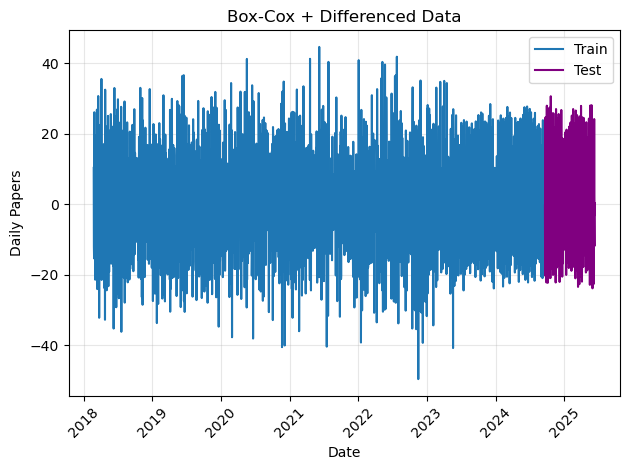

In [36]:
plt.plot(ts_train['YMD_timestamp'],ts_train['paper_diff'], label='Train')
plt.plot(ts_test['YMD_timestamp'],ts_test['paper_diff'], c= 'purple', label='Test')
plt.xlabel('Date')
plt.ylabel('Daily Papers')
plt.title('Box-Cox + Differenced Data')

plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

From the plot, we observe that while differencing produces a relatively constant mean, the Box–Cox–transformed series still exhibits some time-dependent oscillations.

Next, we examine the ACF and PACF. We use the built-in `plot_acf` and `plot_pacf` functions from the `statsmodels` library to compute and visualize the autocorrelation and partial autocorrelation at different time lags. These plots show how strongly the time series is correlated with its own past values. This information is essential for determining how many lag terms should be included in the ARIMA model. In other words, visual inspection of the ACF and PACF helps us choose appropriate values for the $q$ and $p$ parameters, respectively.


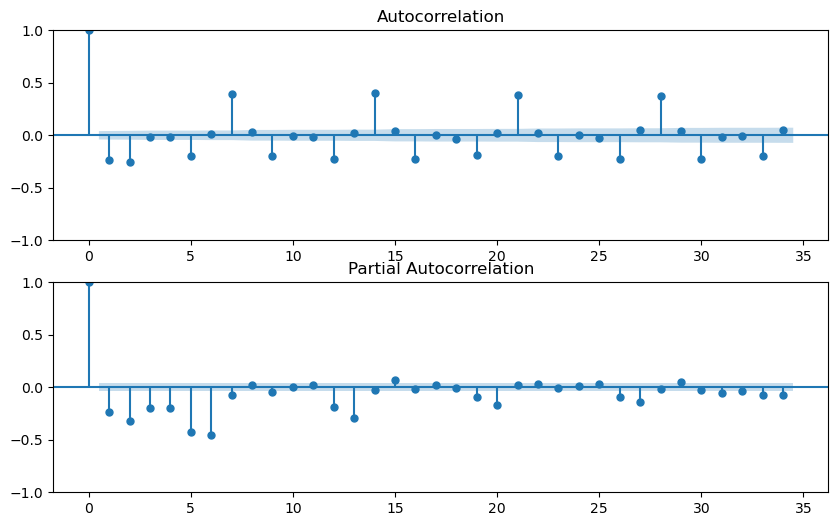

In [37]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, ax = plt.subplots(2,1, figsize=(10, 6))
plot_acf(ts_train['paper_diff'].dropna(), ax = ax[0])
plot_pacf(ts_train['paper_diff'].dropna(), ax = ax[1])

plt.show()

As expected, many lags exhibit statistically significant autocorrelations due to the highly correlated nature of the dataset. Based on visual inspection of the ACF and PACF plots, we select $p = q = 30$ to approximately capture most of the statistically significant lags. Interestingly, the ACF plot also reveals a clear weekly seasonal pattern, indicating that the number of daily published papers is positively correlated on a week-to-week basis.

Let us now train the ARIMA(30, 1, 30) model on the transformed `ts_train['bc_transform']` column using the `fit` method.


In [38]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(ts_train['bc_transform'], order = (30,1,30))

arima_fit = model.fit()


C:\Users\dondarini\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dondarini\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dondarini\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dondarini\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dondarini\AppData\Local\anaconda3\Lib\site-packages\s

Let's make prediction on the test set by calling the `forecast` method.

In [39]:
bc_forecast = arima_fit.forecast(steps= len(ts_test))

C:\Users\dondarini\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dondarini\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Finally, let's perform the inverse Box-Cox transformation to get the actual preditctions on the test set and compare them with the actual test data.

In [40]:
def inv_boxcox(y, lambda_):
    if lambda_ == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lambda_ * y + 1) / lambda_)

arima_predicted = inv_boxcox(bc_forecast, lam)


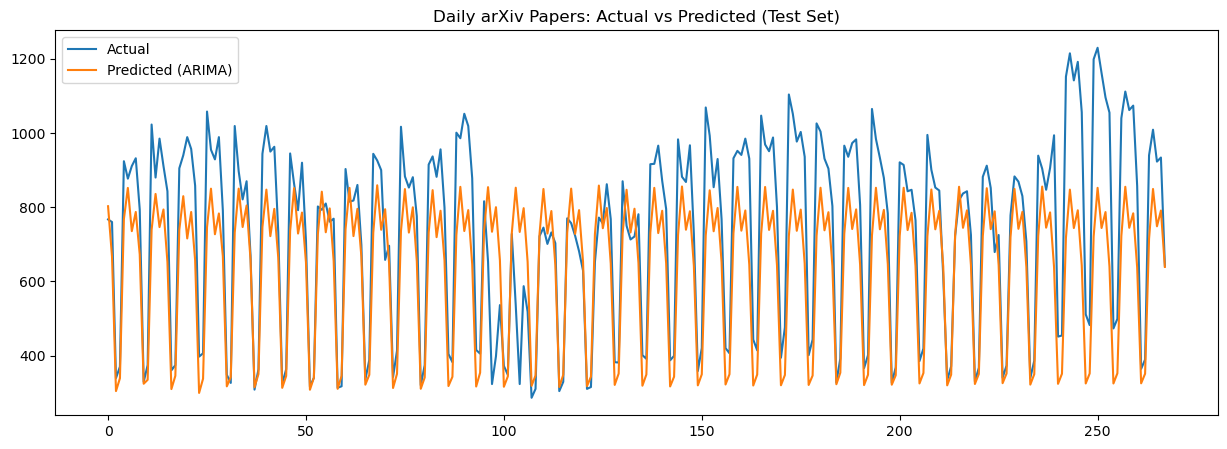

In [41]:
plt.figure(figsize=(15,5))
plt.plot(ts_test['paper_no'].values, label='Actual')
plt.plot(arima_predicted.values, label='Predicted (ARIMA)')

plt.legend()
plt.title("Daily arXiv Papers: Actual vs Predicted (Test Set)")
plt.show()


Also in this case, overlaying the predictions with the actual test data shows that the ARIMA model captures the general oscillatory behavior of the time series but still struggles to reproduce the sharp resonant peaks. Overall, the ARIMA predictions appear less accurate than those obtained with XGBoost.

To quantify this observation, we compute the $R^2$-score on the test set and compare it with the value achieved by the XGBoost model.


In [42]:
r2_test_arima = r2_score(ts_test['paper_no'], arima_predicted)
print("TEST R² - ARIMA:", r2_test_arima)


TEST R² - ARIMA: 0.5910647241401441


As expected, the $R^2$ achieved with ARIMA is lower than the one obtained with XGBoost: 0.59 vs. 0.77. In other words, our ML model outperforms the traditional ARIMA model, improving the $R^2$-score by approximately 23%.


## Conclusions

Time series forecasting remains a fascinating field, offering the opportunity to combine theoretical rigor with practical, real-world insights. In this project, we analyzed publication data from arXiv, a widely used repository for scientific research, with the goal of predicting the daily number of submitted papers.

Our exploratory data analysis revealed a significant shift in publication dynamics: in recent years, AI-related fields have grown rapidly, surpassing the traditionally dominant physics categories. This change highlights evolving research interests across the scientific community.

To model publication trends, we first developed an XGBoost-based forecasting framework, achieving a test $R^2 \approx 0.77$ when predicting daily submissions over approximately a one-year period. To benchmark performance against a classical statistical approach, we then built an ARIMA model. Examination of the ACF and PACF plots indicated strong nonlinearity and long-range dependencies in the data—patterns that are difficult for traditional linear models like ARIMA to capture effectively. As expected, the ARIMA model performed worse, reaching an $R^2 \approx 0.59$.

Overall, XGBoost outperformed ARIMA, improving the $R^2$ score by roughly **23%**. This result underscores the advantage of machine learning models when dealing with complex, nonlinear time series such as scientific publication rates.

Possible future directions include expanding the prediction window, incorporating additional external features (e.g., category-level activity or seasonality signals), and further improving the XGBoost model through a more exhaustive hyperparameter search.
